In [1]:
%matplotlib inline

In [2]:
%run notebook_setup.py

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.special import factorial
from scipy.optimize import minimize
from tqdm import tqdm
import starry
print(starry.__version__)
import earthshine

1.0.0.dev0


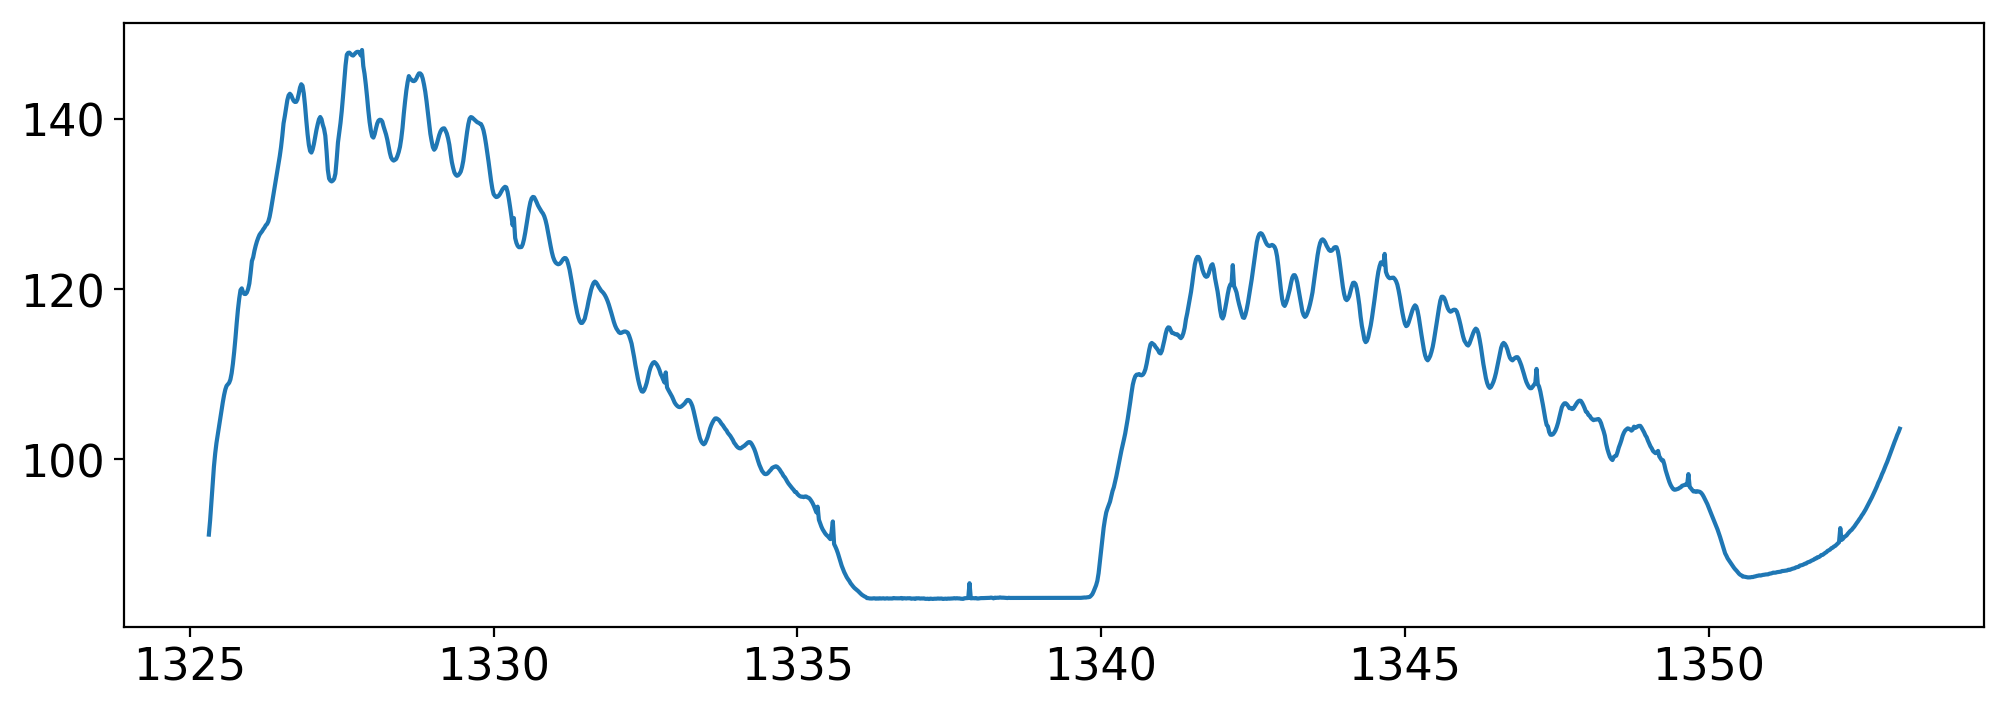

In [4]:
# Import data
data = pd.read_csv("../data/sector1_2_2_medians.csv")
time = np.array(data["start_time"])
flux = np.array(data["median_flux"])
inds = np.argsort(time)
time = time[inds]
flux = flux[inds]
plt.plot(time, flux);

In [5]:
bkg = np.nanmin(flux)
print(bkg)

83.56655121


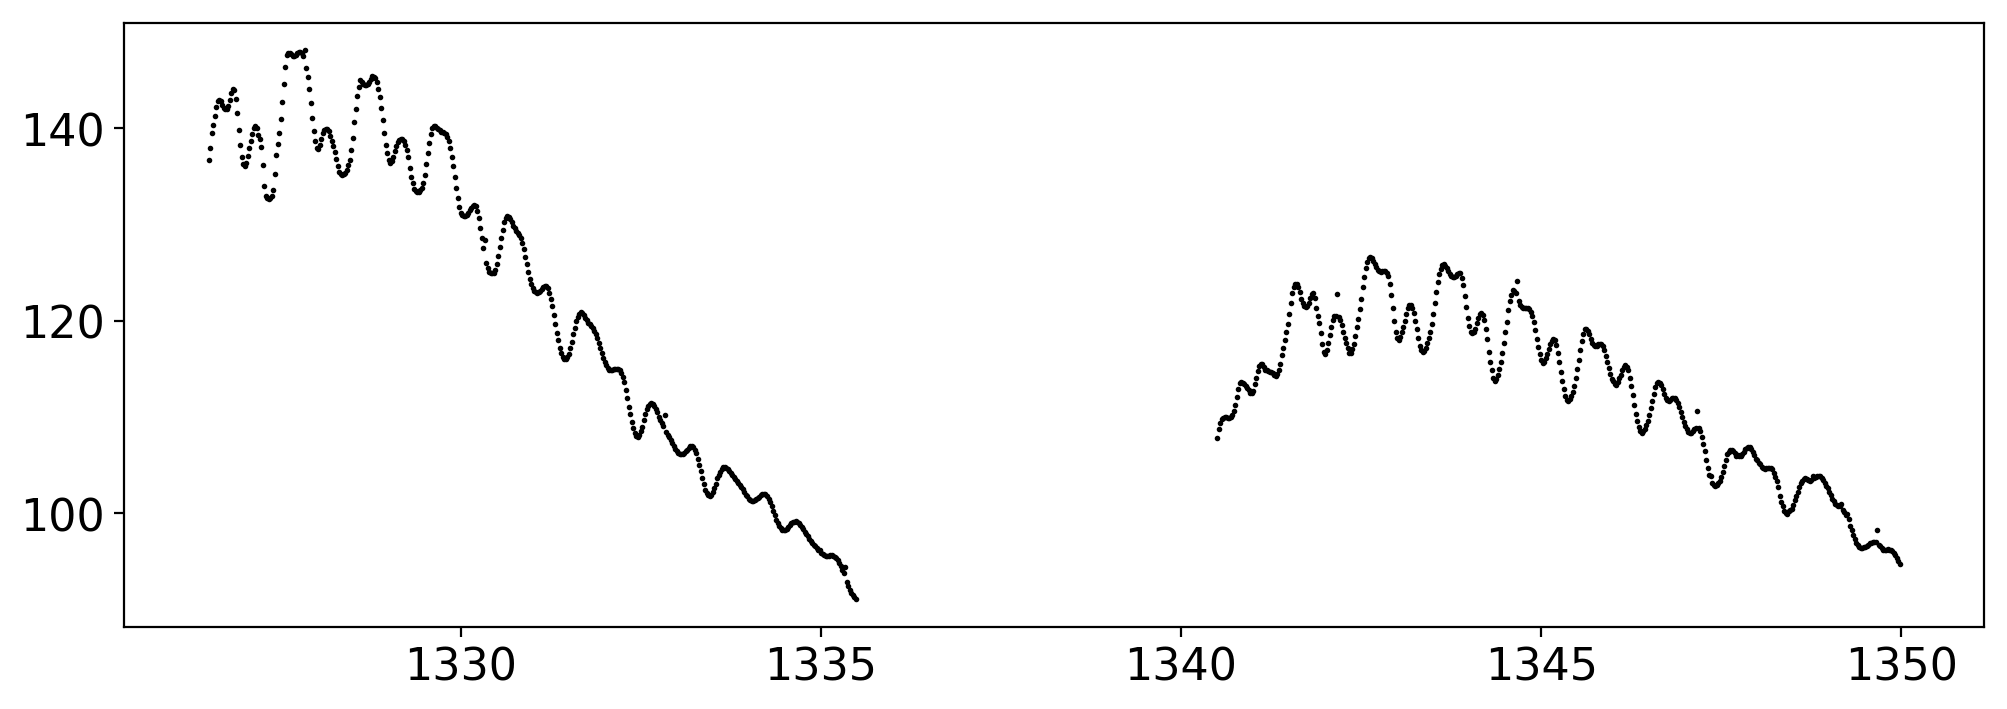

In [6]:
# Remove indices where Earth isn't visible
no_earth = np.where(((time < 1326.5)) |
                    ((time > 1335.5) & (time < 1340.5)) |
                    ((time > 1350))
                   )[0]
time = np.delete(time, no_earth)
flux = np.delete(flux, no_earth)
plt.plot(time, flux, 'k.', ms=2);

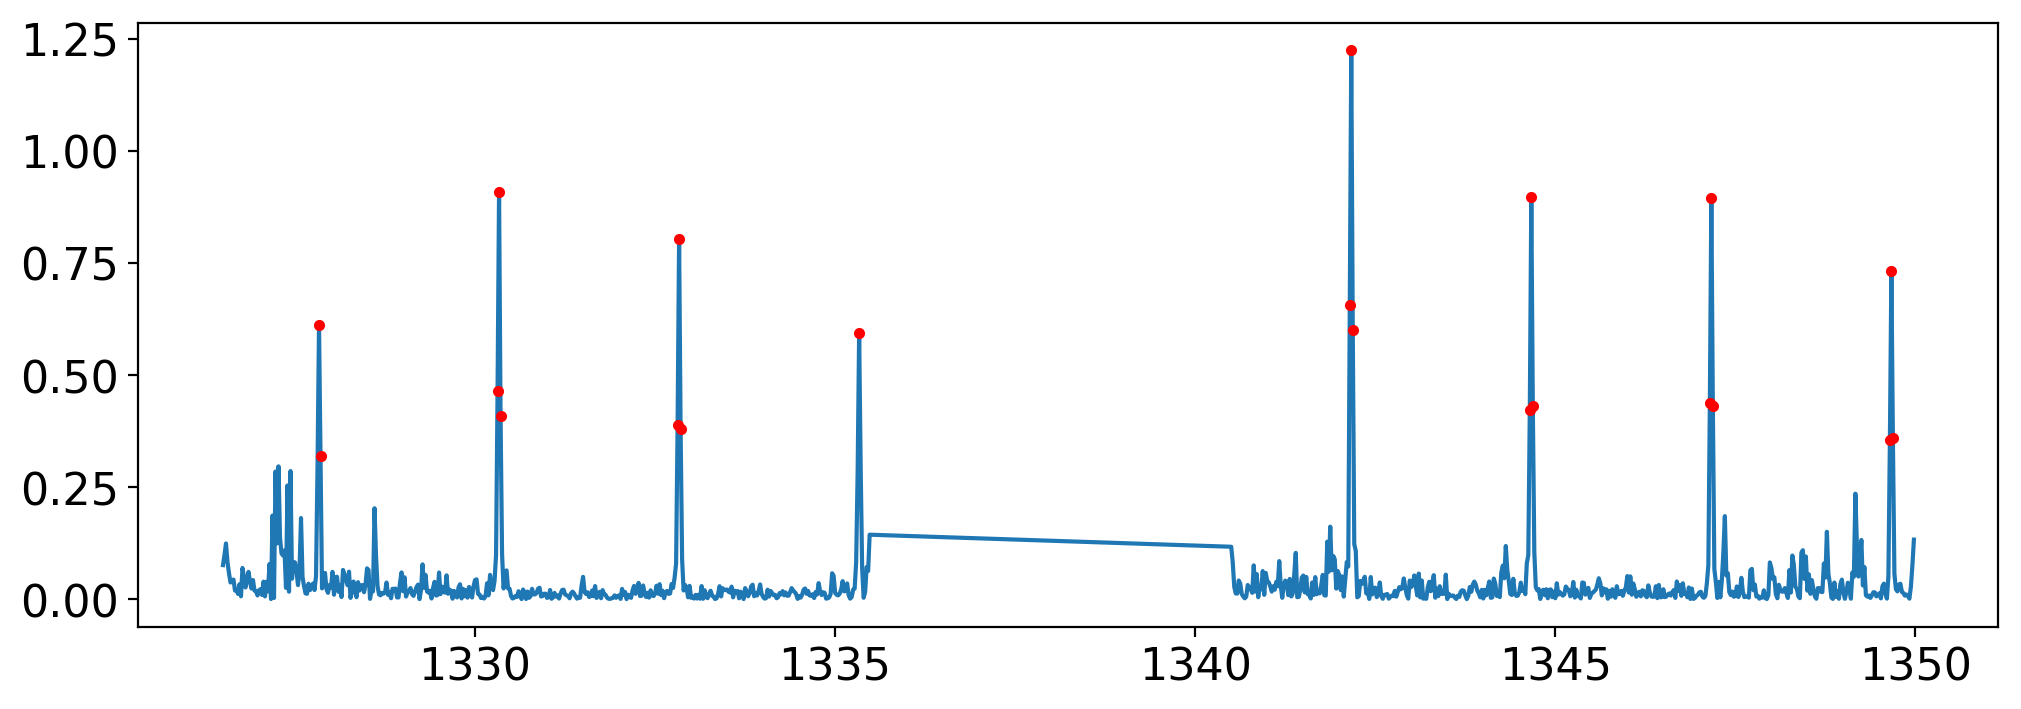

In [7]:
# Find outliers
import celerite
from celerite import terms

kernel = (terms.SHOTerm(-5.1764392316836405, 1.6107542577563405, 2.655821848765415) + 
          terms.SHOTerm(-5.7045029853481175, 3.2344017903155295, 1.8378770664093453) + 
          terms.JitterTerm(-3.17071374788726) + 
          terms.Matern32Term(-0.7774349567978974, -0.7022573115788371, eps=0.01))
gp = celerite.GP(kernel, mean=np.mean(flux))
gp.compute(time, 1e-5)

pred_mean = gp.predict(flux, time, return_var=False)[0]
resid = np.abs(flux - pred_mean)
cut = 3 * np.std(resid)
plt.plot(time, resid)
bad = np.where(resid > cut)
plt.plot(time[bad], resid[bad], 'r.');

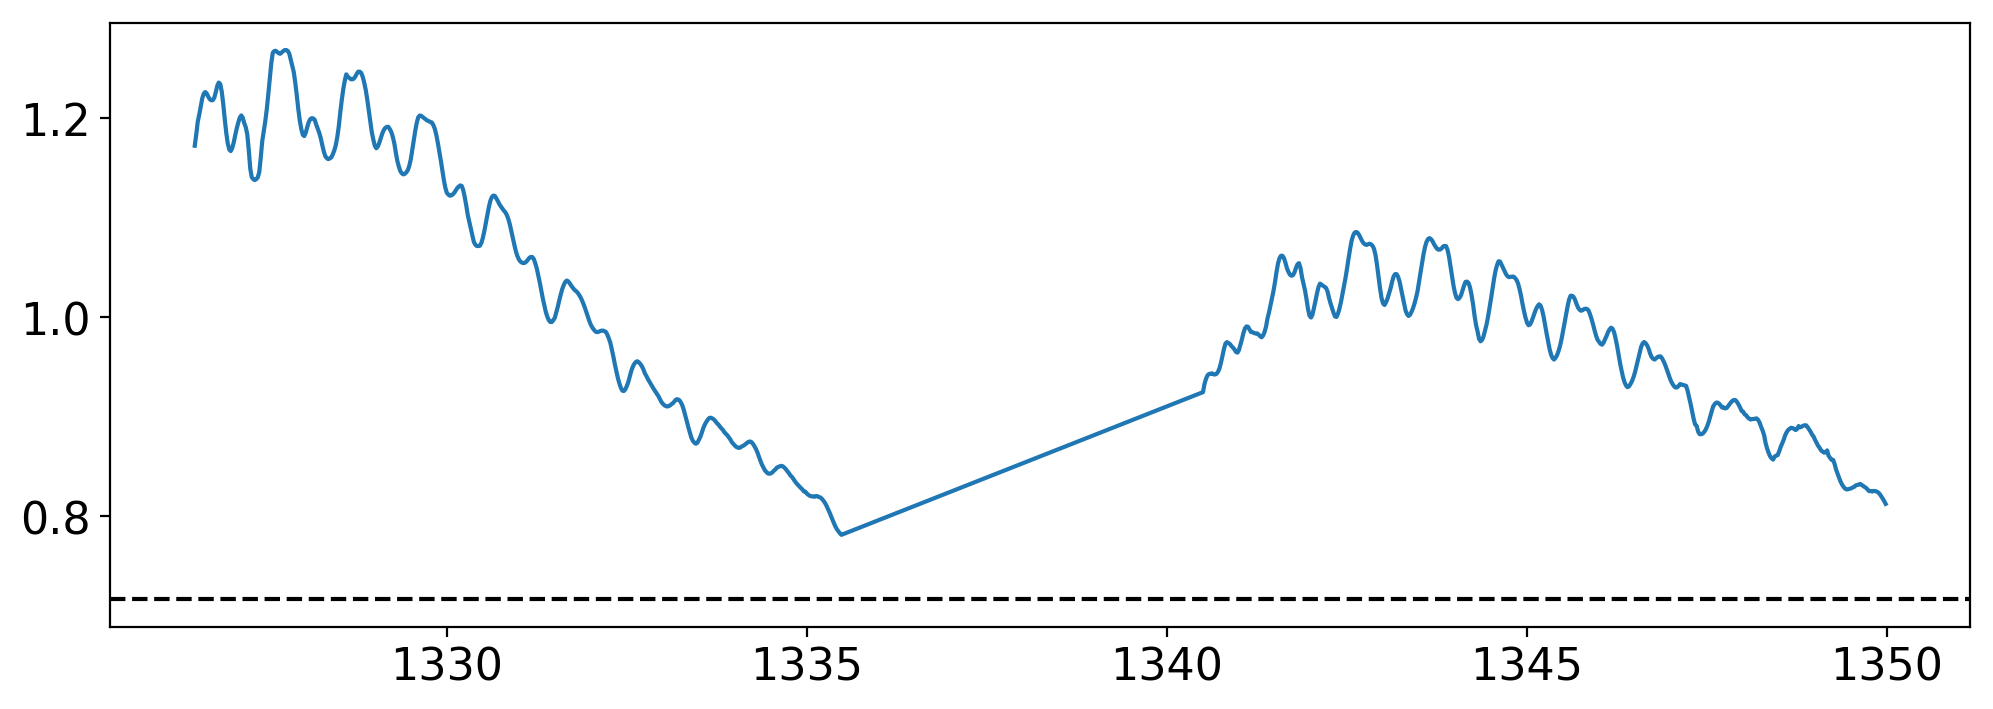

In [8]:
# Remove them
time = np.delete(time, bad)
flux = np.delete(flux, bad)

# Normalize the flux
norm = np.nanmedian(flux)
flux /= norm
bkg /= norm

# Flux error estimate (very crude)
flux_err = 1e-4

# Plot it
plt.plot(time, flux)
plt.axhline(bkg, color="k", ls="--");

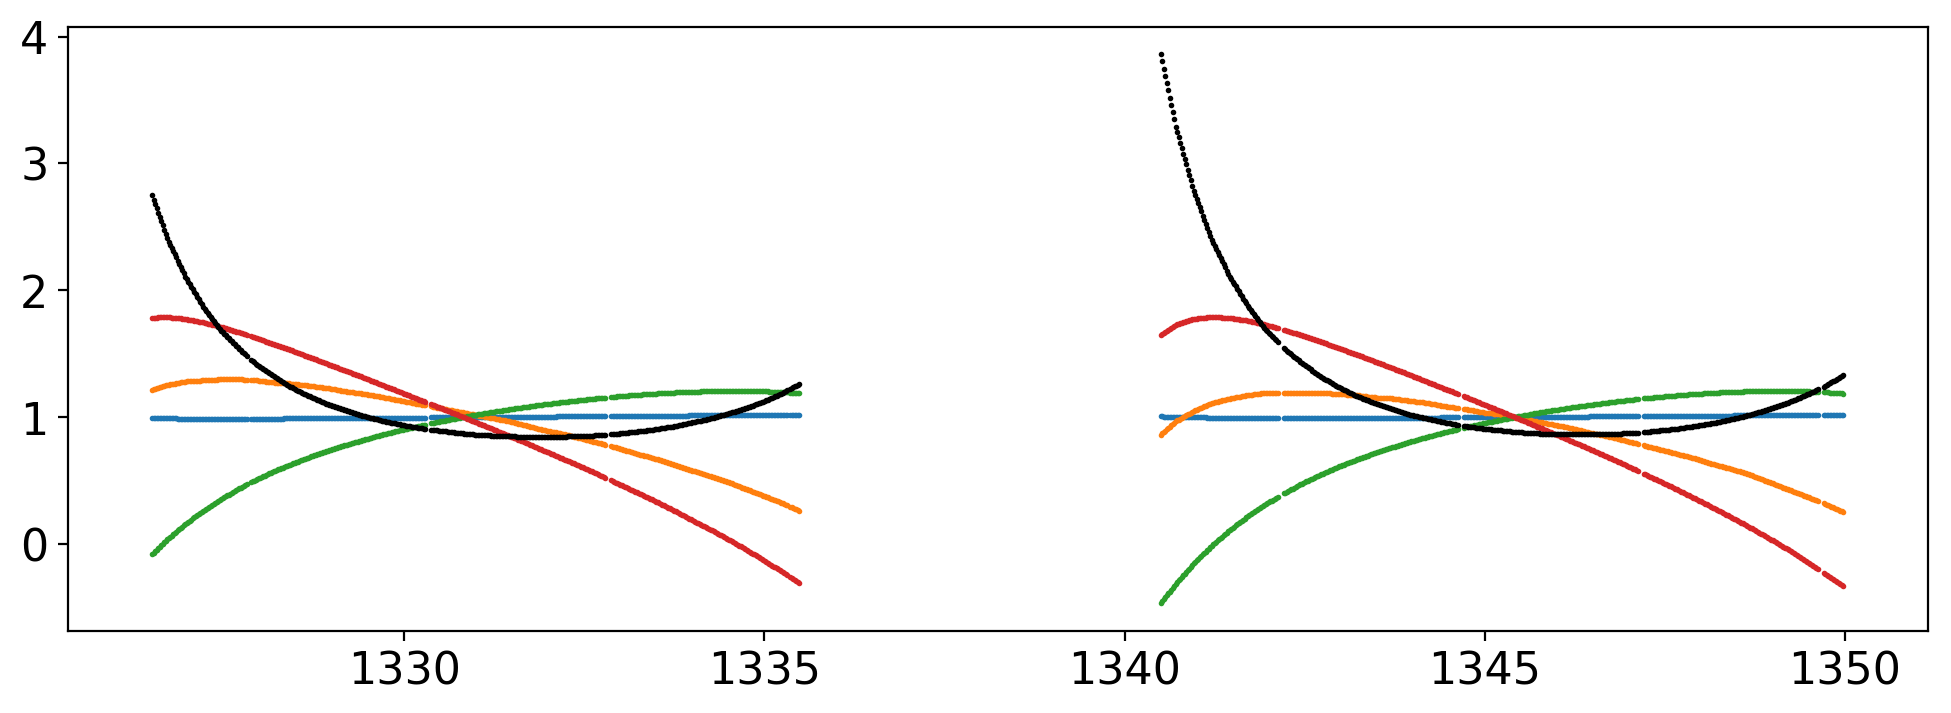

In [9]:
# Get housekeeping variables
angles = pd.read_csv("../data/emangles_S1_O9_d-54.dat", sep="\s+", header=0)
tjd = np.array(angles["TJD"])
cosalt = np.interp(time, tjd, np.cos(np.pi / 180 * np.array(angles["E:alt"])))
sinalt = np.interp(time, tjd, np.sin(np.pi / 180 * np.array(angles["E:alt"])))
cosaz = np.interp(time, tjd, np.cos(np.pi / 180 * np.array(angles["E:az"])))
sinaz = np.interp(time, tjd, np.sin(np.pi / 180 * np.array(angles["E:az"])))
invr2 = np.interp(time, tjd, 1.0 / (np.array(angles["E:dist"]) ** 2))

# Normalize them
cosalt /= np.nanmedian(cosalt)
sinalt /= np.nanmedian(sinalt)
cosaz /= np.nanmedian(cosaz)
sinaz /= np.nanmedian(sinaz)
invr2 /= np.nanmedian(invr2)

# Plot them
plt.plot(time, cosalt, '.', ms=2)
plt.plot(time, sinalt, '.', ms=2)
plt.plot(time, cosaz, '.', ms=2)
plt.plot(time, sinaz, '.', ms=2)
plt.plot(time, invr2, '.', ms=2, color="k");

# Inference

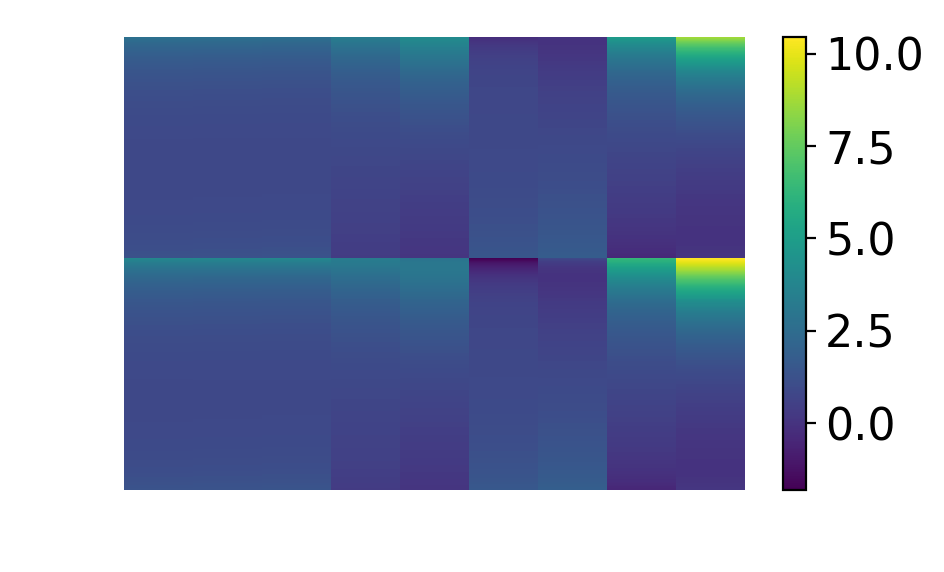

In [10]:
# The multiplicative baseline model
B_order = 3
B = np.hstack((
        np.vander(cosalt, N=B_order, increasing=True),
        np.vander(sinalt, N=B_order, increasing=True)[:, 1:],
        np.vander(cosaz, N=B_order, increasing=True)[:, 1:],
        np.vander(sinaz, N=B_order, increasing=True)[:, 1:]
))

# We know that the flux *has* to be proportional
# to 1 / r^2, so we multiply that in here
B *= invr2.reshape(-1, 1)

# Plot it
fig, ax = plt.subplots(1, figsize=(5, 3))
im = ax.imshow(B, aspect="auto")
plt.colorbar(im)
ax.axis('off');

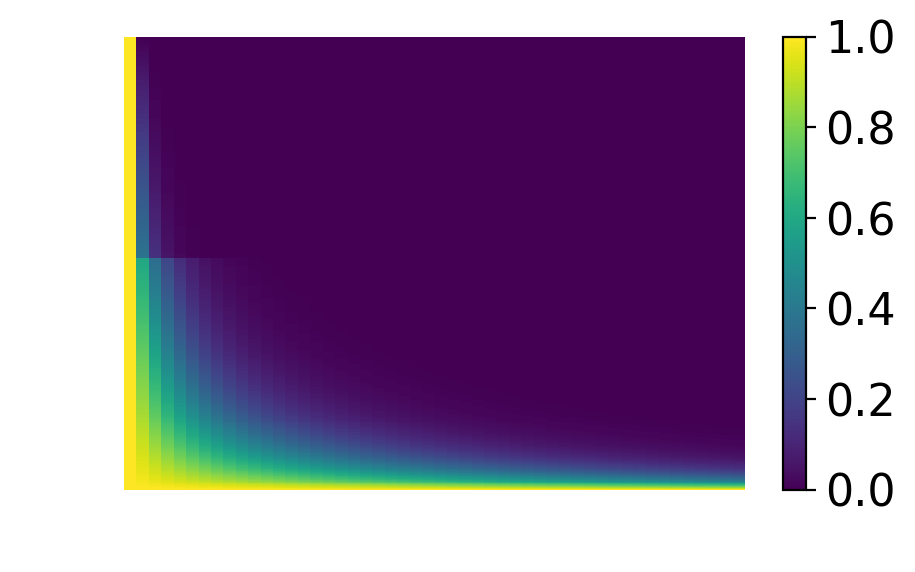

In [11]:
# The additive baseline model
C_order = 50
t = (time - time[0]) / (time[-1] - time[0])
C = np.vander(t, N=C_order, increasing=True)

# Plot it
fig, ax = plt.subplots(1, figsize=(5, 3))
im = ax.imshow(C, aspect="auto")
plt.colorbar(im)
ax.axis('off');

100%|██████████| 867/867 [00:00<00:00, 3970.89it/s]


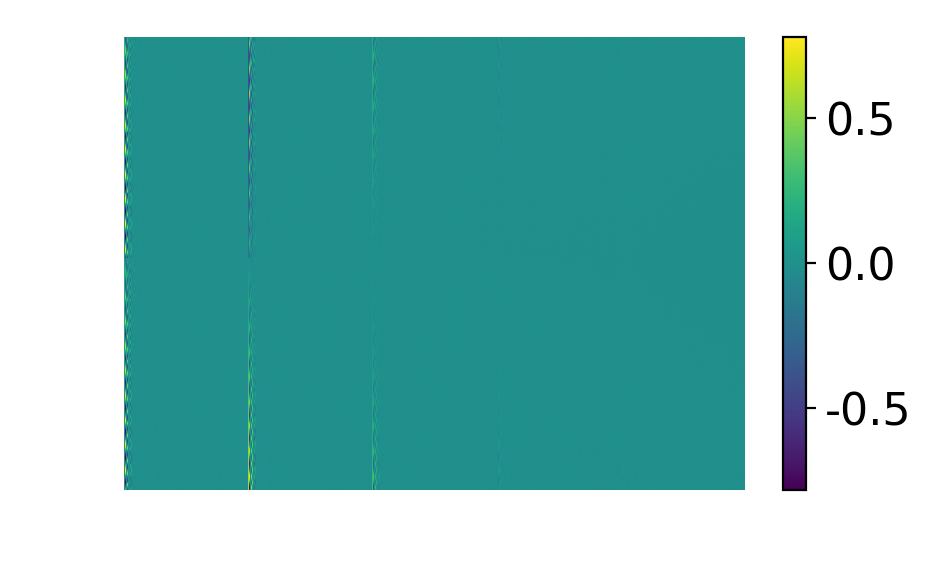

In [36]:
# The starry model
ydeg = 15
nt = 5
phase0 = 0.0
ny = (ydeg + 1) ** 2

# Exposure time integration
nexp = 10
delta = (1. / 48.) * np.linspace(-1, 1, nexp, endpoint=True)
X = np.empty((nexp, len(time), ny * nt))
for i in range(nexp):
    X[i] = earthshine.design_matrix(time + delta[i], ydeg=ydeg, nt=nt, phase0=phase0, fit_linear_term=True)
X = np.mean(X, axis=0)
    
# Plot it
fig, ax = plt.subplots(1, figsize=(5, 3))
im = ax.imshow(X, aspect="auto")
plt.colorbar(im)
ax.axis('off');

In [37]:
# Define the L2 prior on the map
lt = np.array([1e-3 * factorial(n) for n in range(nt)]) ** 2
LX = np.ones(ny * nt)
for n in range(nt):
    LX[n * ny:(n + 1) * ny] = lt[n]
LX[0] = (1e3) ** 2

# Define the L2 prior on the multiplicative model
LB = np.ones(B.shape[1])

# Define the L2 prior on the additive model
LC = np.ones(C.shape[1])

In [43]:
# The diagonal of the covariance matrix
D = np.ones_like(flux) * flux_err ** 2

# Initialize the starry model to a constant
# and the additive baseline to the avg background guess
Xwx = np.ones_like(flux)
Cwc = 0 * bkg * np.ones_like(flux)
Bwb = 0.25 * np.ones_like(flux)

# Iterate!
niter = 1000
loss = np.zeros(niter)
for n in tqdm(range(niter)):
    wb = starry.MAP(B, LB, D / Xwx ** 2, (flux - Cwc) / Xwx)
    Bwb = np.dot(B, wb)

    wc = starry.MAP(C, LC, D, flux - (Bwb * Xwx))
    Cwc = np.dot(C, wc)

    wx = starry.MAP(X, LX, D / Bwb ** 2, (flux - Cwc) / Bwb)
    Xwx = np.dot(X, wx)
    
    model = Bwb * Xwx + Cwc
    loss[n] = 0.5 * np.sum(((flux - model) / (flux_err)) ** 2) / len(flux)

100%|██████████| 1000/1000 [00:45<00:00, 22.06it/s]


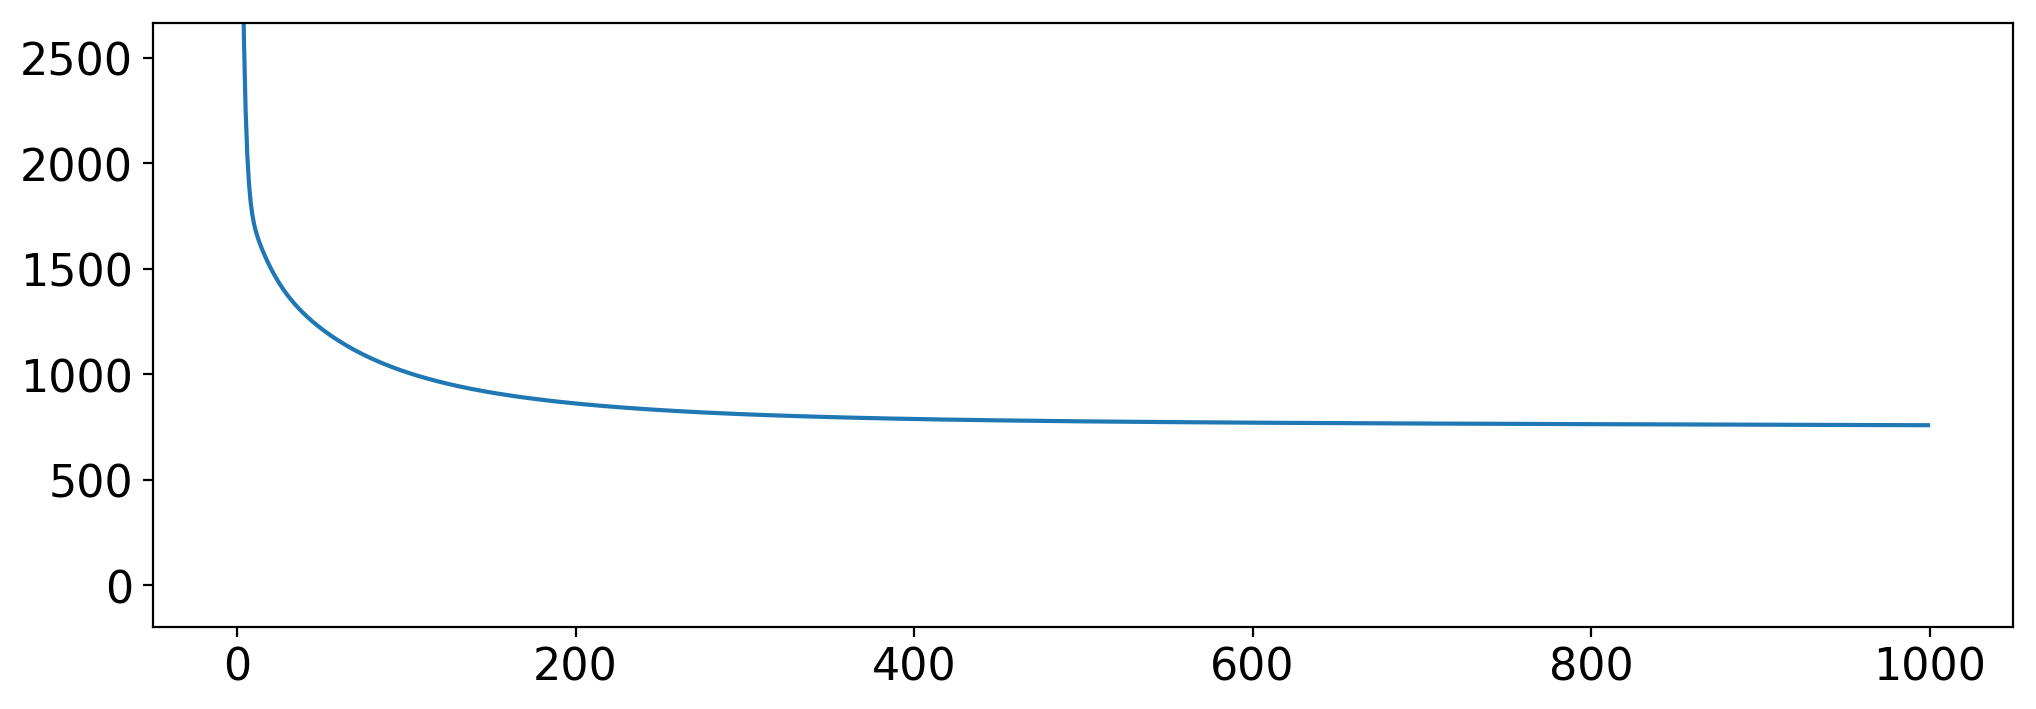

In [44]:
fig, ax = plt.subplots(1)
ax.plot(loss)
burn = 10
lo = np.min(loss[burn:])
hi = np.max(loss[burn:])
rng = hi - lo
ax.set_ylim(lo - rng, hi + rng);

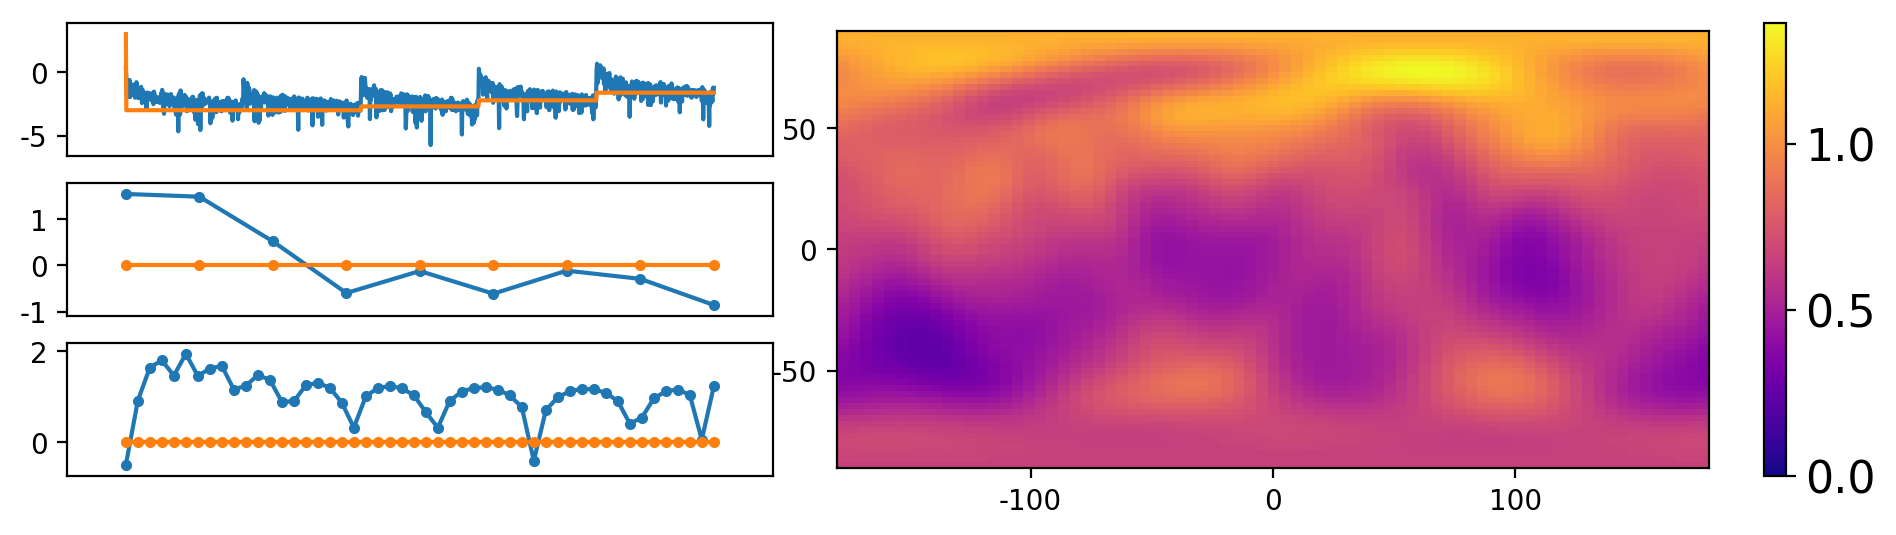

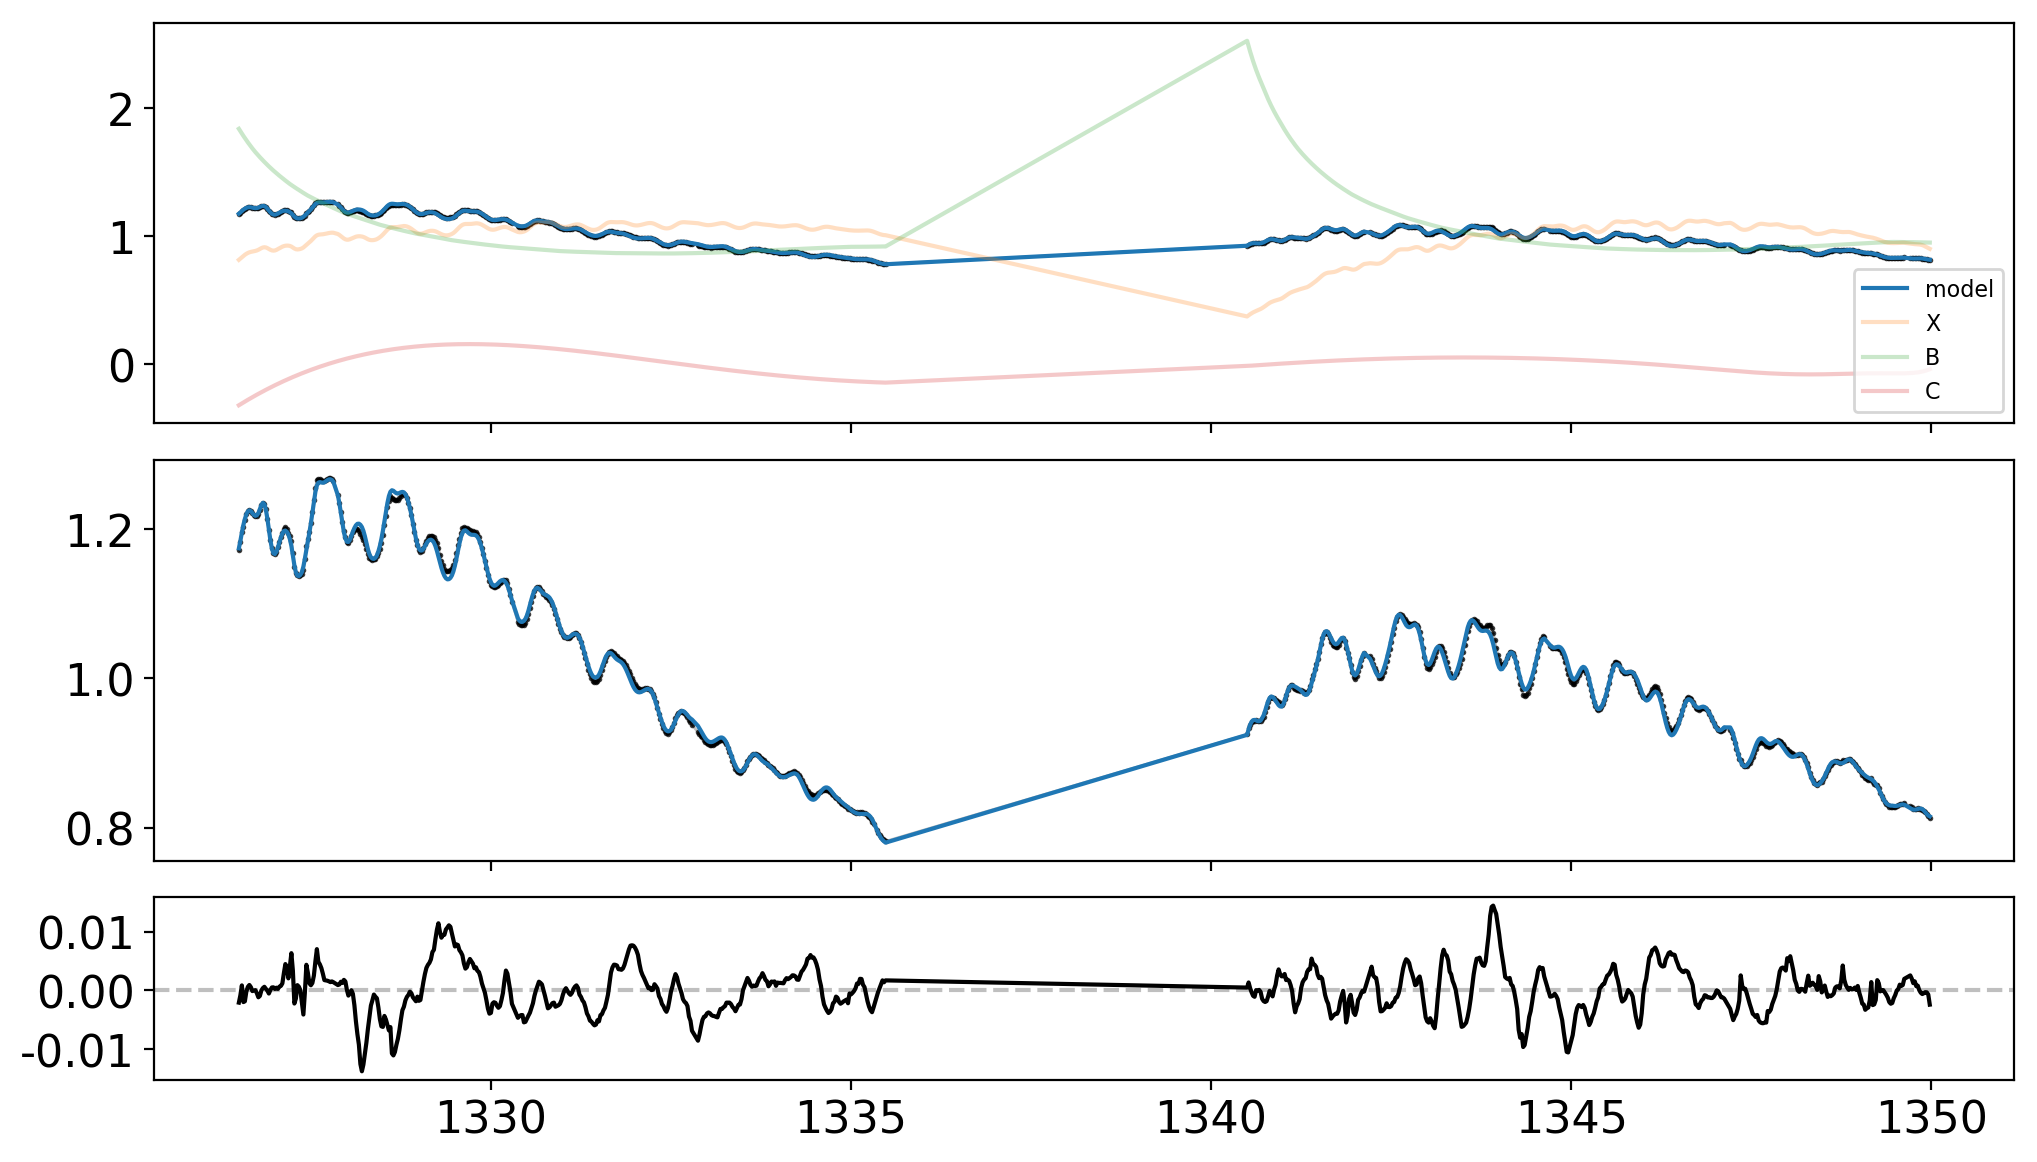

In [45]:
# Set the map coefficients
map = starry.Map(ydeg=ydeg, nt=nt, reflected=True)
for n in range(nt):
    map[:, :, n] = wx[n * ny:(n + 1) * ny]

# Plot the coefficients and the map at t = 0
fig = plt.figure(figsize=(12, 3))
ax = [plt.subplot2grid((3, 5), (0, 0), rowspan=1, colspan=2),
      plt.subplot2grid((3, 5), (1, 0), rowspan=1, colspan=2),
      plt.subplot2grid((3, 5), (2, 0), rowspan=1, colspan=2),
      plt.subplot2grid((3, 5), (0, 2), rowspan=3, colspan=3)]
for i, axis in enumerate(ax):
    for tick in axis.xaxis.get_major_ticks() + axis.yaxis.get_major_ticks():
        tick.label.set_fontsize(10)
    if i < 3:
        axis.set_xticks([])
        axis.margins(0.1, 0.1)
ax[0].plot(np.log10(np.abs(wx)), '-')
ax[0].plot(np.log10(np.sqrt(LX)), '-')
ax[1].plot(np.log10(np.abs(wb)), '.-')
ax[1].plot(np.log10(np.sqrt(LB)), '.-')
ax[2].plot(np.log10(np.abs(wc)), '.-')
ax[2].plot(np.log10(np.sqrt(LC)), '.-')
cmap = plt.get_cmap("plasma")
cmap.set_under('w')  
Z = map.render(t=0, res=75, projection="rect", source=None)[0]
vmin = 0
vmax = None #1
im = ax[3].imshow(Z, origin="lower", cmap=cmap, extent=(-180, 180, -90, 90), vmin=vmin, vmax=vmax);
fig.colorbar(im)

# Plot the data and model
fig = plt.figure(figsize=(12, 7))
ax = [plt.subplot2grid((5, 1), (0, 0), rowspan=2, colspan=1),
      plt.subplot2grid((5, 1), (2, 0), rowspan=2, colspan=1),
      plt.subplot2grid((5, 1), (4, 0), rowspan=1, colspan=1)]
ax[0].plot(time, flux, 'k.', alpha=0.75, ms=2)
ax[0].plot(time, flux, 'k-', alpha=0.25, lw=1)
ax[0].plot(time, model, color="C0", label="model");
ax[0].plot(time, Xwx, color="C1", alpha=0.25, label="X");
ax[0].plot(time, Bwb, color="C2", alpha=0.25, label="B");
ax[0].plot(time, Cwc, color="C3", alpha=0.25, label="C");
ax[0].legend(fontsize=8, loc="lower right")
ax[0].set_xticklabels([])
ax[1].plot(time, flux, 'k.', alpha=0.75, ms=2)
ax[1].plot(time, flux, 'k-', alpha=0.25, lw=1)
ax[1].plot(time, model, color="C0", label="model");
ax[1].set_xticklabels([])
ax[2].plot(time, flux - model, color="k");
ax[2].axhline(0, color="k", alpha=0.25, ls="--");

In [47]:
flux_num = earthshine.animate(map, time, res=50)

100%|██████████| 867/867 [00:23<00:00, 35.46it/s]


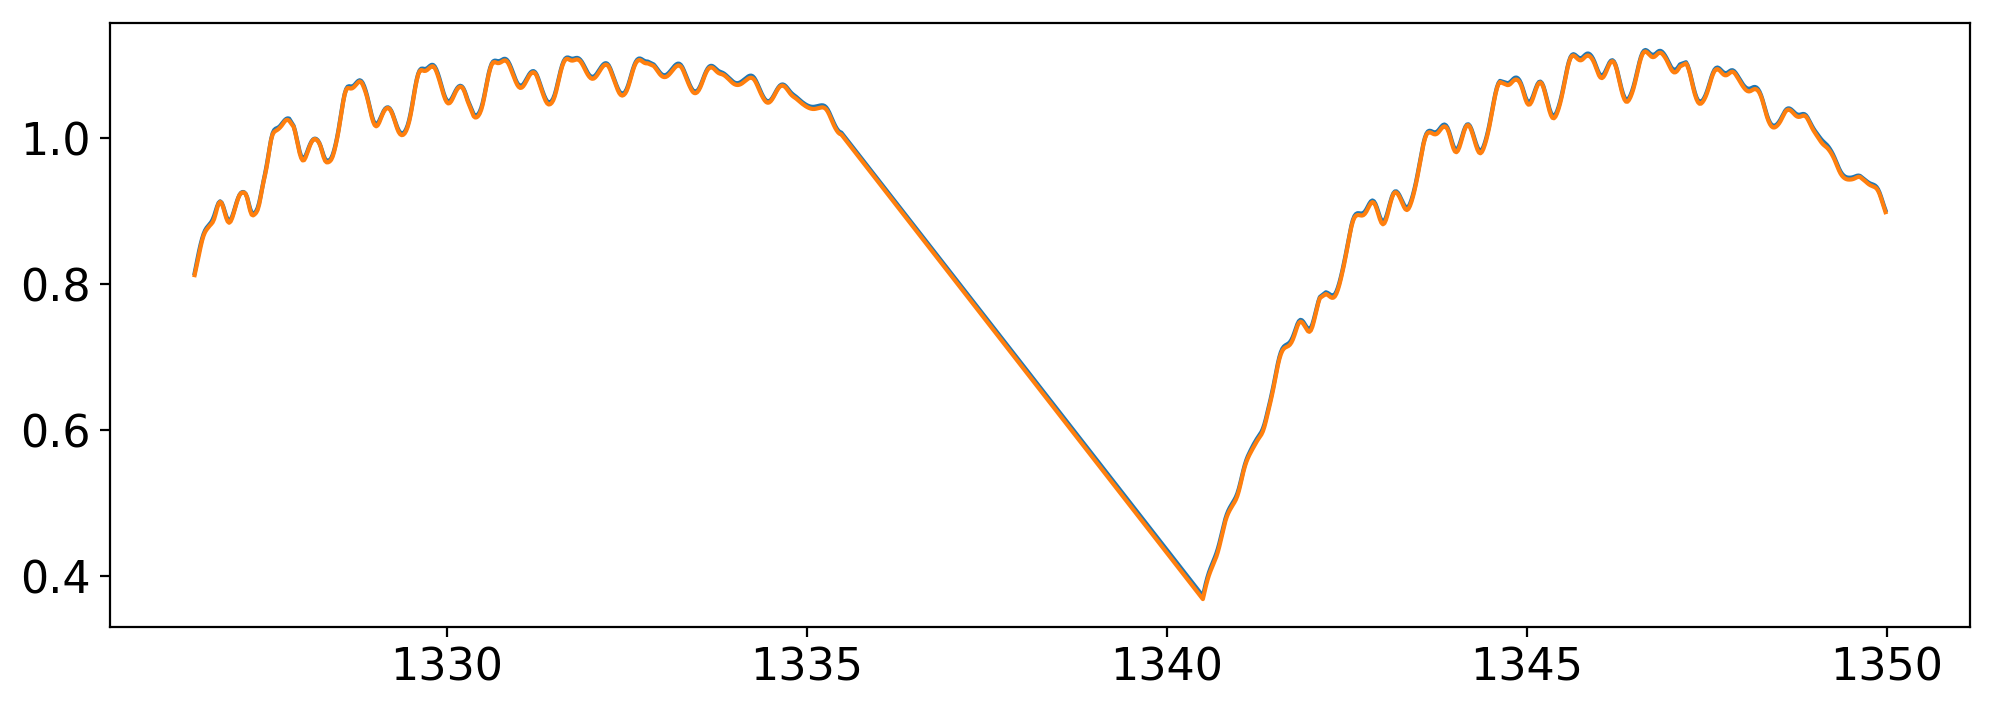

In [48]:
plt.plot(time, Xwx);
plt.plot(time, flux_num / 600);